In [1]:
import numpy as np
import skimage
import skimage.io
import cv2
from os.path import join, exists
import pickle
import os
import math
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [18]:
%matplotlib inline

In [2]:
def img_ssimRecog(img, len_s = 11):
    X_org, Y_org = img.shape
    res_list = []
    for i in range(0, int(X_org), int(X_org / len_s)+3):
        for j in range(0, int(Y_org), int(Y_org / len_s)+3):
            res_list.append(ssimFunction(img[i:i + len_s, j:j + len_s]))

    res_list = np.array(res_list)
    res_list_sort = res_list[np.lexsort(-res_list.T)]
    res_list = res_list_sort[:, :1]

    res = np.mean(res_list[:10])
    if res < 0.0:
        res = 0.0
    return 1 - res

In [3]:
def entropyFunc(img):
    res = 0
    tmp = [0] * 256
    img_list = []
    for i in range(len(img)):
        img_list.extend(map(int, img[i]))
    img_list_set = set(img_list)
    for i in img_list_set:
        tmp[i] = float(img_list.count(i))/ 256

    for i in range(len(tmp)):
        if (tmp[i] == 0):
            res = res
        else:
            res = float(res - tmp[i] * (math.log(tmp[i]) / math.log(2.0)))
    return res

In [4]:
def ssimFunction(img):
    x, y = img.shape
    resEntropy = entropyFunc(img)
    TR = cv2.GaussianBlur(img, (5,5),3)
    G = cv2.Sobel(img,cv2.CV_16S,2,2)/5
    Gr = cv2.Sobel(TR,cv2.CV_16S,2,2)/5
    Ux = np.mean(G)
    Uy = np.mean(Gr)
    Vx = np.var(G)
    Vy = np.var(Gr)
    Vxy = (1 / (x * y - 1)) * np.sum((G - Ux) * (Gr - Uy))
    R = 255
    K1 = 0.03
    K2 = 0.01
    c1 = (K1 * R) ** 2
    c2 = (K2 * R) ** 2
    # -SSIM
    A1 = 2 * Ux * Uy + c1
    A2 = 2 * Vxy + c2
    B1 = Ux ** 2 + Uy ** 2 + c1
    B2 = Vx  + Vy  + c2
    SSIM = (A1 * A2) / (B1 * B2)

    return SSIM, resEntropy

In [13]:
data_dir = '/home/ubuntu/projects/data/deepsolar2/cleaned'

In [12]:
# image info dict
# key1: folder_idx, keys2: image_file_name, value: [SSIM_score, Laplacian_score, external_source(1: watermark, 0: no_watermark)]
image_info_dict = {}


In [23]:
missing_img_info = {
    '6083_48294_2017': ['2007_0.png', '2007_1.png', '2009_0.png', '2009_1.png']
}

In [30]:
for x in ['test']:
    print(x)
    image_dir = join(data_dir, 'sequence_0', x)
    for folder in tqdm(os.listdir(image_dir)):
        county, idx, install_year = folder.split('_')
        if exists(join(image_dir, folder, 'img_info.txt')):
            with open(join(image_dir, folder, 'img_info.txt'), 'r') as f:
                lr_images = f.readlines()
            lr_images = set([x[:-1] for x in lr_images])
        else:
            print(folder)
            lr_images = set(missing_img_info[folder])

        image_info_dict[idx] = {}
        
        for f in sorted(os.listdir(join(image_dir, folder))):
            if f[-4:] != '.png':
                continue
            image = cv2.imread(join(image_dir, folder, f))
            image = image[50:580, :, :]
            img2gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            score_ssim = img_ssimRecog(img2gray)  # SSIM metrics
            score_laplace = cv2.Laplacian(img2gray, cv2.CV_64F).var()  # Laplacian metrics
            
            if f in lr_images:
                external_source = 1
            else:
                external_source = 0
            
            image_info_dict[idx][f] = [score_ssim, score_laplace, external_source]


  0%|          | 0/265 [00:00<?, ?it/s]

test



 59%|█████▉    | 156/265 [02:00<01:23,  1.31it/s]


100%|██████████| 265/265 [03:24<00:00,  1.29it/s]

In [32]:
with open('/home/ubuntu/projects/historical_solar/image_info_dict.pickle', 'wb') as f:
    pickle.dump(image_info_dict, f)

In [33]:
ssim_list_dict = {0: [], 1: []}
lpl_list_dict = {0: [], 1: []}
for idx in image_info_dict.keys():
    for f in image_info_dict[idx].keys():
        ssim, lpl, external_source = image_info_dict[idx][f]
        ssim_list_dict[external_source].append(ssim)
        lpl_list_dict[external_source].append(lpl)

(-10, 500)

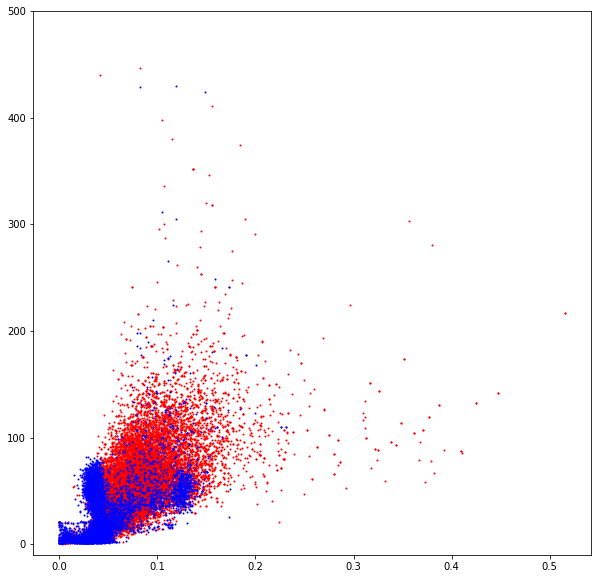

In [38]:
plt.figure(figsize=(10, 10))
plt.scatter(ssim_list_dict[0], lpl_list_dict[0], s=1, color='red')
plt.scatter(ssim_list_dict[1], lpl_list_dict[1], s=1, color='blue')
plt.ylim(-10, 500)

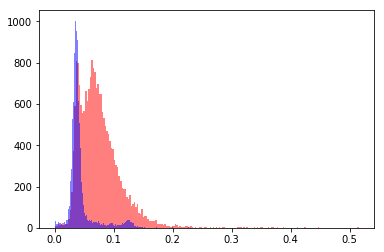

In [42]:
_ = plt.hist(ssim_list_dict[0], bins=200, color='red', alpha=0.5)
_ = plt.hist(ssim_list_dict[1], bins=200, color='blue', alpha=0.5)

(0, 250)

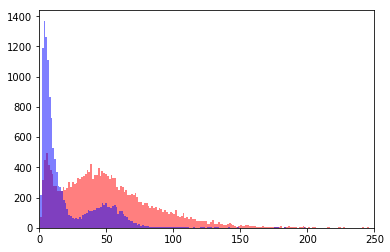

In [45]:
_ = plt.hist(lpl_list_dict[0], bins=2000, color='red', alpha=0.5)
_ = plt.hist(lpl_list_dict[1], bins=2000, color='blue', alpha=0.5)
plt.xlim(0, 250)

(0, 25)

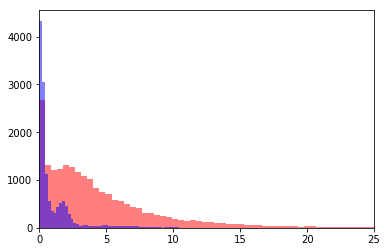

In [50]:
_ = plt.hist(np.array(lpl_list_dict[0]) * np.array(ssim_list_dict[0]), bins=500, color='red', alpha=0.5)
_ = plt.hist(np.array(lpl_list_dict[1]) * np.array(ssim_list_dict[1]), bins=500, color='blue', alpha=0.5)
plt.xlim(0, 25)